In [ ]:
#Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Dataset load

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


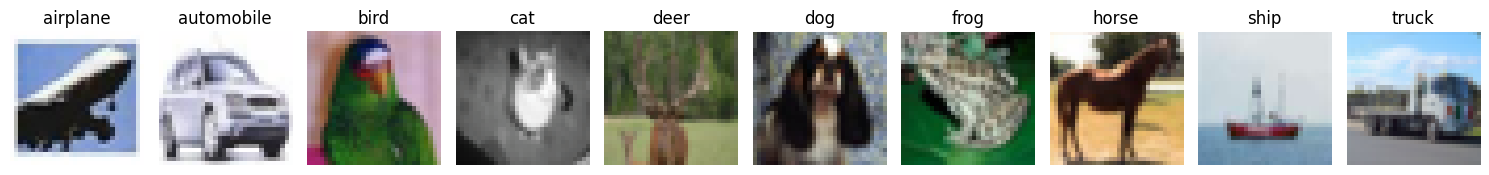

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Preprocessing ---
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# --- Load datasets ---
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)

# --- Function to show one sample per class ---
def show_all_classes(loader, classes):
    class_samples = {}
    for images, labels in loader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if lbl not in class_samples:
                class_samples[lbl] = img
            if len(class_samples) == len(classes):
                break
        if len(class_samples) == len(classes):
            break

    plt.figure(figsize=(15, 4))
    for i, cls in enumerate(classes):
        img = class_samples[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        # unnormalize
        img = img * np.array(std) + np.array(mean)
        img = np.clip(img, 0, 1)
        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Call the function ---
show_all_classes(train_loader, classes)


In [ ]:
# Visualize

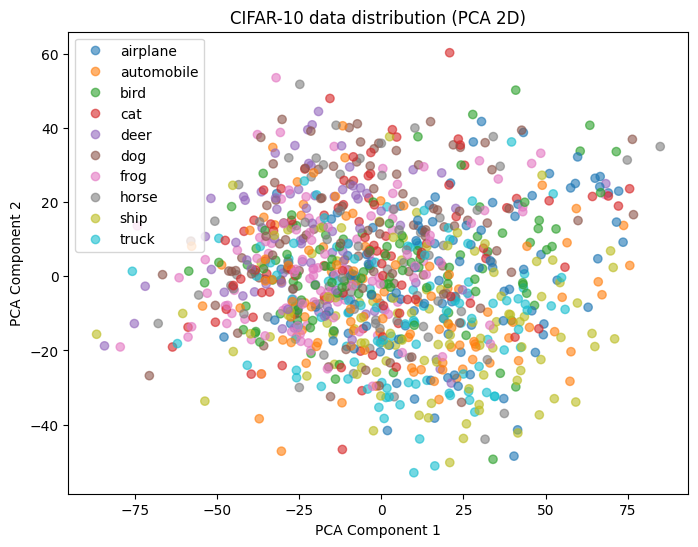

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch

# 2. Scatter plot of distribution using PCA
def scatter_distribution(loader, num_samples=1000):
    data_iter = iter(loader)
    images, labels = [], []
    count = 0

    while count < num_samples:
        imgs, lbls = next(data_iter)
        images.append(imgs)
        labels.append(lbls)
        count += imgs.size(0)

    images = torch.cat(images)[:num_samples]
    labels = torch.cat(labels)[:num_samples]

    # Flatten images
    images_flat = images.view(num_samples, -1).numpy()

    # PCA to 2D
    pca = PCA(n_components=2)
    images_2d = pca.fit_transform(images_flat)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(images_2d[:,0], images_2d[:,1], c=labels.numpy(), cmap='tab10', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title("CIFAR-10 data distribution (PCA 2D)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

scatter_distribution(train_loader)


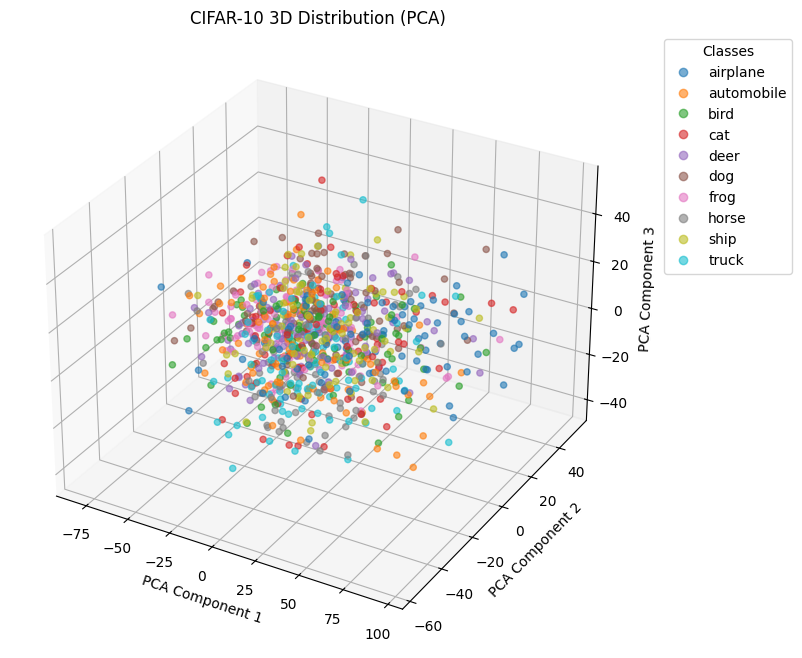

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 3D Scatter plot using PCA
def scatter_3d(loader, classes, num_samples=1000):
    data_iter = iter(loader)
    images, labels = [], []
    count = 0

    while count < num_samples:
        imgs, lbls = next(data_iter)
        images.append(imgs)
        labels.append(lbls)
        count += imgs.size(0)

    images = torch.cat(images)[:num_samples]
    labels = torch.cat(labels)[:num_samples]

    # Flatten images
    images_flat = images.view(num_samples, -1).numpy()

    # PCA to 3D
    pca = PCA(n_components=3)
    images_3d = pca.fit_transform(images_flat)

    # Plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        images_3d[:,0], images_3d[:,1], images_3d[:,2],
        c=labels.numpy(), cmap='tab10', alpha=0.6
    )

    # Create legend
    handles, _ = scatter.legend_elements()
    ax.legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    ax.set_title("CIFAR-10 3D Distribution (PCA)")
    plt.show()

# Run the function
scatter_3d(train_loader, classes)


In [ ]:
# Create the model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # safe flatten for any batch size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_model():
    return SimpleCNN().to(device)

# 4 Loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
# Define optimization function

In [ ]:
def get_optimizers(model):
    return {
        # Part-I
        "BatchGD": lambda params: optim.SGD(params, lr=0.01),
        "MiniBatchSGD": lambda params: optim.SGD(params, lr=0.01),
        "SGD": lambda params: optim.SGD(params, lr=0.01),
        # Part-II
        "GD": lambda params: optim.SGD(params, lr=0.01),
        "Momentum": lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
        "Nesterov": lambda params: optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
        # Part-III
        "AdaGrad": lambda params: optim.Adagrad(params, lr=0.01),
        "RMSProp": lambda params: optim.RMSprop(params, lr=0.001),
        "Adam": lambda params: optim.Adam(params, lr=0.001)
    }


In [ ]:
# Define training and evaluation function

In [ ]:
def train_and_track(model, optimizer, train_loader, test_loader, epochs=20):
    acc_list = []
    f1_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Average training loss
        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        acc_list.append(acc)
        f1_list.append(f1)

        print(f"Epoch {epoch+1}/{epochs} -> Loss: {epoch_loss:.4f}, Val Acc: {acc:.4f}, Val F1: {f1:.4f}")

    return acc_list, f1_list


In [ ]:
# Execute the model training and evaluation using each optimizers


Training Part-I - BatchGD...
Epoch 1/20 -> Loss: 1.7262, Val Acc: 0.4460, Val F1: 0.4221
Epoch 2/20 -> Loss: 1.3079, Val Acc: 0.5501, Val F1: 0.5504
Epoch 3/20 -> Loss: 1.1335, Val Acc: 0.6179, Val F1: 0.6174
Epoch 4/20 -> Loss: 1.0136, Val Acc: 0.6351, Val F1: 0.6367
Epoch 5/20 -> Loss: 0.9168, Val Acc: 0.6754, Val F1: 0.6755
Epoch 6/20 -> Loss: 0.8349, Val Acc: 0.6581, Val F1: 0.6484
Epoch 7/20 -> Loss: 0.7659, Val Acc: 0.6909, Val F1: 0.6897
Epoch 8/20 -> Loss: 0.7016, Val Acc: 0.7127, Val F1: 0.7077
Epoch 9/20 -> Loss: 0.6385, Val Acc: 0.6898, Val F1: 0.6853
Epoch 10/20 -> Loss: 0.5775, Val Acc: 0.7118, Val F1: 0.7092
Epoch 11/20 -> Loss: 0.5224, Val Acc: 0.7144, Val F1: 0.7159
Epoch 12/20 -> Loss: 0.4661, Val Acc: 0.7203, Val F1: 0.7196
Epoch 13/20 -> Loss: 0.4095, Val Acc: 0.6975, Val F1: 0.6906
Epoch 14/20 -> Loss: 0.3560, Val Acc: 0.7165, Val F1: 0.7169
Epoch 15/20 -> Loss: 0.3026, Val Acc: 0.7196, Val F1: 0.7211
Epoch 16/20 -> Loss: 0.2517, Val Acc: 0.7181, Val F1: 0.7136
Epo

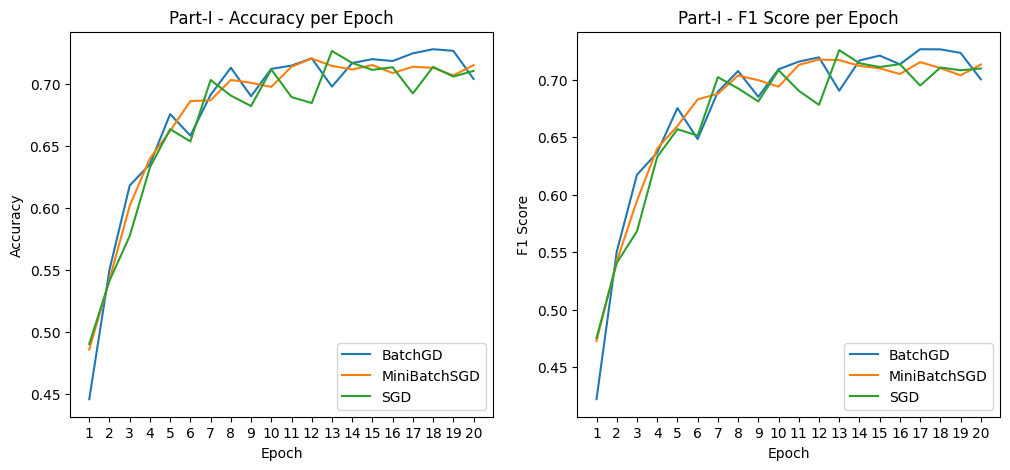

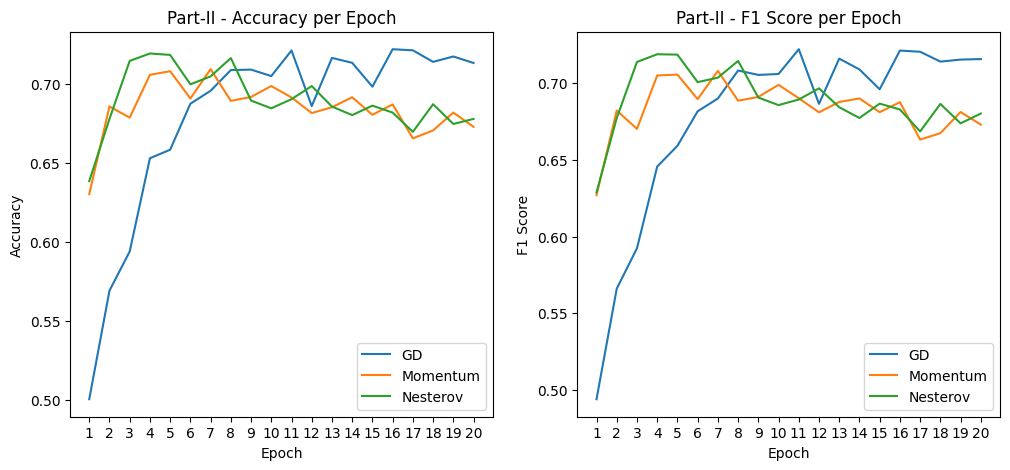

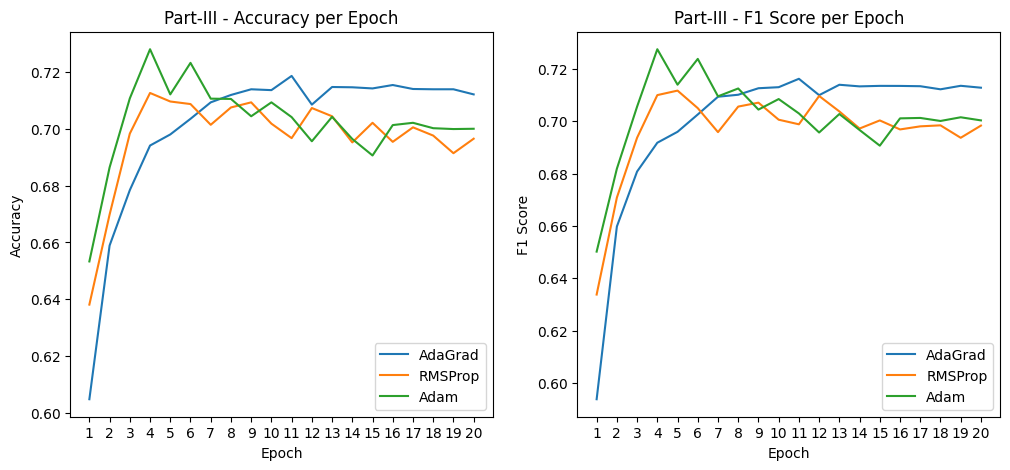

In [ ]:
# -------------------------------
# 7️⃣ Run all optimizers
# -------------------------------
optimizer_groups = {
    "Part-I": ["BatchGD", "MiniBatchSGD", "SGD"],
    "Part-II": ["GD", "Momentum", "Nesterov"],
    "Part-III": ["AdaGrad", "RMSProp", "Adam"]
}

epochs = 20
all_results = {}

for part_name, optim_list in optimizer_groups.items():
    all_results[part_name] = {}
    for opt_name in optim_list:
        print(f"\nTraining {part_name} - {opt_name}...")
        model = create_model()
        optimizer = get_optimizers(model)[opt_name](model.parameters())
        acc_list, f1_list = train_and_track(model, optimizer, train_loader, test_loader, epochs)
        all_results[part_name][opt_name] = {"Accuracy": acc_list, "F1": f1_list}

# -------------------------------
# 8️⃣ Visualize per epoch
# -------------------------------
for part_name, optim_dict in all_results.items():
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    for opt_name, metrics in optim_dict.items():
        plt.plot(range(1, epochs+1), metrics["Accuracy"], label=opt_name)
    plt.title(f"{part_name} - Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(range(1, epochs+1))
    plt.legend()

    # F1 Score
    plt.subplot(1,2,2)
    for opt_name, metrics in optim_dict.items():
        plt.plot(range(1, epochs+1), metrics["F1"], label=opt_name)
    plt.title(f"{part_name} - F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.xticks(range(1, epochs+1))
    plt.legend()

    plt.show()